## Transfer learning tutorial

This tutorial is adopted from python-engineer's video on Transfer learning -- [Link](https://github.com/python-engineer/pytorchTutorial/blob/master/15_transfer_learning.py)

What is transfer learning? 

Transfer learning is a technique where a deep-learning model trained on another problem (which usually has lot of data and good accuracy for that task) is slightly modified to be used on a new problem. This is an important concept as building an entirely new model might not be take a long time or there might not be enough data for the training of that particular task. The idea is the weights/parameters of the model at the start of the layers have similar functionality and assist in better performance on the new task. Usually we freeze the weights training of the hidden layers an tweak the output layer slightly to account for the change in the task.

So for example, maybe you could have the neural network learn to recognize objects like cats and then use that knowledge or use part of that knowledge to help you do a better job reading x-ray scans. This is called transfer learning. Sometimes you can start with the weights and biases of a published netowrks as a starting point. More details about Transfer Learning can be found [here](https://cs231n.github.io/transfer-learning/)

In this example will be using the CNN model and modify ONLY the last layers of the model to use for our case. ResNet-18 CNN model is being used. This model is trained on millions on images with 1000 image categories. 

In [1]:
import time 
import os 
import copy 
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [4]:
data_dir = 'transfer_learning_dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


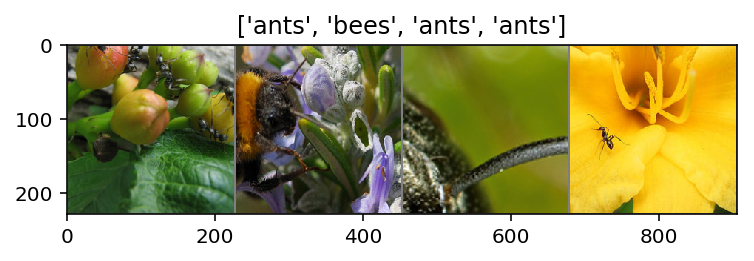

In [5]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() #Step in the scheduler 

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Method 1: Fine tuning of the model -- 
1. Download the model (ResNet18 in this case) 
2. Change the output of the final layer 
3. Re-train the model 

In [7]:
#Load a pre-trained model -- ResNet18 model 
model = torchvision.models.resnet18(pretrained=True)
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 2) #Number of classes in the end 
model.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001)

#Scheduler to update the learning rate for the SGD 
'''
After every 7 steps in the optimizer the learning rate will be multiplied by 0.1 
'''
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1) 

In [8]:
model = train_model(model, criterion=criterion, optimizer=optimizer, scheduler=step_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6055 Acc: 0.7049
val Loss: 0.4489 Acc: 0.8235

Epoch 1/4
----------
train Loss: 0.5534 Acc: 0.7500
val Loss: 0.3887 Acc: 0.8497

Epoch 2/4
----------
train Loss: 0.4884 Acc: 0.7705
val Loss: 0.3122 Acc: 0.9150

Epoch 3/4
----------
train Loss: 0.4332 Acc: 0.8361
val Loss: 0.2654 Acc: 0.9477

Epoch 4/4
----------
train Loss: 0.4943 Acc: 0.7541
val Loss: 0.2701 Acc: 0.9216

Training complete in 5m 11s
Best val Acc: 0.947712


### Method 2: Freeze penultimate weights
In this case ONLY the weights of the final layer are trained. This might reduce the accuracy but would greatly reduce the amount of time taken to fit the model since the number of weights to be optimized is greatly reduced. 

In [9]:
#Load a pre-trained model -- ResNet18 model 
model = torchvision.models.resnet18(pretrained=True)

#Method to freeze the layer parameters -- just get the require grad attribute to FALSE!  
for param in model.parameters(): 
    param.requires_grad = False 

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2) #Number of classes in the end 
model.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=0.001)

#Scheduler to update the learning rate for the SGD 
'''
After every 7 steps in the optimizer the learning rate will be multiplied by 0.1 
'''
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1) 
model = train_model(model, criterion=criterion, optimizer=optimizer, scheduler=step_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6906 Acc: 0.5779
val Loss: 0.5356 Acc: 0.7451

Epoch 1/4
----------
train Loss: 0.5765 Acc: 0.7254
val Loss: 0.4247 Acc: 0.8497

Epoch 2/4
----------
train Loss: 0.5298 Acc: 0.7541
val Loss: 0.3511 Acc: 0.8954

Epoch 3/4
----------
train Loss: 0.5081 Acc: 0.7377
val Loss: 0.3169 Acc: 0.8954

Epoch 4/4
----------
train Loss: 0.4822 Acc: 0.7787
val Loss: 0.2967 Acc: 0.9020

Training complete in 2m 19s
Best val Acc: 0.901961


Using fine-tuning and re-training all the weights for the new network take longer than having the weights fixed. While the accuracy suffers when doing so, the final result is not too bad considering we did not have to make a network from scratch or initialize the weights for it. Given the network is deep, optimizing the weights for this network from scratch would have been difficult and time consuming. For such a case, transfer learning seems to be a good option. 